# Apple Quality Prediction with AI

This model will be based on generic algorithms. Prediction based on Deep Learning Model is not included.

### Few Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin, clone
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,StackingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,silhouette_score,roc_curve

from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture

### Reading Data from CSV and verifying the data

In [2]:
## Reading CSV

randomness = 42
apple_data = pd.read_csv("apple_quality.csv")

In [3]:
## Verifying CSV

print("\n*** Apple Data Headers and few values ***\n")
print(apple_data.head())

print("============================")
print("\n*** Apple Data Info ***\n")
print(apple_data.info())


*** Apple Data Headers and few values ***

   A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0   0.0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1   1.0 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2   2.0 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3   3.0 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4   4.0  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

        Acidity Quality  
0  -0.491590483    good  
1  -0.722809367    good  
2   2.621636473     bad  
3   0.790723217    good  
4   0.501984036    good  

*** Apple Data Info ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 

<span style="background-color:red; color:white">**NOTE:** Acidity is having one extra value (Count: 4001) than others (Count: 4000). <br> **Steps** : Dropping the null values</span>

### Data Celanup

In [4]:
apple_data = apple_data.dropna()
apple_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 312.5+ KB


<span style="background-color:green; color:white">Now Acidity is having 4000 columns</span>

### Separating x and y. Also separating train, validation and test set

Train set will be used for training only, Validation set will be used to validate the score.
Test set will be used to understand performace at the end. This set will be considered as not seen by model while training. Hence the score in test set can be considered as performance score in unseen data

In [5]:
## Functions to get x,y and split train,test set

def get_x_y(data):
    x = data.iloc[:,1:-1] ## A-id is not required in this case. 
    y = data.iloc[:,-1]
    return x,y

def split_train_test(x,y,test_size=0.2,random_state=42):
    split = StratifiedShuffleSplit(n_splits=1,test_size=test_size,random_state=random_state)
    for train_index,test_index in split.split(x,y):
        train_x = x[train_index]
        train_y = y[train_index]
        test_x = x[test_index]
        test_y = y[test_index]
        return train_x,train_y,test_x,test_y

In [6]:
## Getting X and Y
x,y = get_x_y(apple_data)

## Getting train set, test set, val set
train_val_x,train_val_y,test_x,test_y = split_train_test(x.values,y.values,random_state=randomness)
train_x,train_y,val_x,val_y = split_train_test(train_val_x,train_val_y,test_size=0.15,random_state=randomness)

### Analyzing X

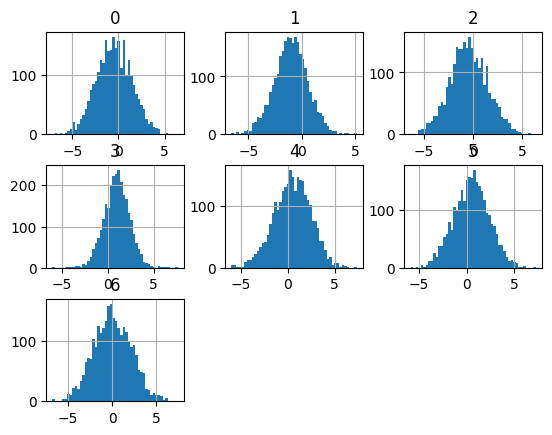

In [7]:
## Checking Histogram for distribution

pd.DataFrame(train_x.astype('float64')).hist(bins=50)
plt.show()

Histogram seems bell-shaped and data is well distributed

### Scaling and Encoding X and Y

In [8]:
## Preparing scalers and encoders

class X_Floater(BaseEstimator,TransformerMixin):
    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        return x.astype('float64')

x_scaler = Pipeline([
    ('floater', X_Floater()),
    ('x_scaler',StandardScaler())
])

class Y_ENC(BaseEstimator,TransformerMixin):
    def __init__(self,transformer=OrdinalEncoder()):
        self._transformer = transformer

    def fit(self,x):
        x_tmp = x.reshape(-1,1)
        self._transformer.fit(x_tmp)
        return self

    def transform(self,x):
        x_tmp = x.reshape(-1,1)
        transformed_x = self._transformer.transform(x_tmp)
        return transformed_x.ravel()
        
    def inverse_transform(self,x):
        x_tmp = x.reshape(-1,1)
        transformed_x = self._transformer.inverse_transform(x_tmp)
        return transformed_x.ravel()


In [9]:
## Encoding and scaling

y_encoder = Y_ENC()

x_scaler.fit(train_x)
y_encoder.fit(train_y)

scaled_train_x = x_scaler.transform(train_x)
encoded_train_y = y_encoder.transform(train_y)
scaled_val_x = x_scaler.transform(val_x)
encoded_val_y = y_encoder.transform(val_y)

### Few Additional Functions

In [10]:
## Few Required Functions 
def view_cv_score(scores):
    max_score = np.max(scores)
    min_score = np.min(scores)
    mean_score = np.mean(scores)
    daviation = np.std(scores)
    print(f"""
Total Number of scores: {len(scores)}
Mean Score:    {mean_score.__round__(2)}
Max Score:     {max_score.__round__(2)}
Min Score:     {min_score.__round__(2)}
St. Daviation: {daviation.__round__(3)}
Scores:        {scores}
""")


def view_score(y_true,y_predicted):
    score = accuracy_score(y_true,y_predicted)
    confused = confusion_matrix(y_true,y_predicted)
    print(f"""
Accuracy Score: {score}
Confusion Matrix:
{confused}
""")


def get_primary_view(model,x,y,val_x,val_y):
    model_cloned = clone(model)
    
    ## Getting Cross validation score based on accuracy in train set
    try:
        model_scores = cross_val_score(model_cloned,x,y,scoring='accuracy',cv=10)
        print("Cross Validation Score")
        view_cv_score(model_scores)
    except:
        pass
    ## Training Log Reg
    model_cloned.fit(x,y)
    
    ## Score in Validation set
    val_y_predicted = model_cloned.predict(val_x)
    print("Validation Score")
    view_score(val_y,val_y_predicted)


def plot_rocs(models,x,y):
    accuracy_scores = {}
    fig =  plt.figure()
    ax = fig.add_subplot(111)
    for each_name,model in models:
        try:
            cusmod = CustomModel(model)
            proba = cusmod.decision_function(x)
            fpr,tpr,thresh = roc_curve(y,proba)
            ax.plot(fpr,tpr,label="{}".format(each_name))
        except:
            raise
    ax.plot([0,1],[0,1])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend()
    plt.grid()
    plt.show()
        

## A custom estimator which provides both predict_proba and decission_function

class CustomModel(BaseEstimator,TransformerMixin):
    def __init__(self,model):
        self.model = model

    def fit(self,x,y,*args,**kw):
        self.model.fit(x,y,*args,**kw)
        return self

    def predict(self,x):
        return self.model.predict(x)

    def predict_proba(self,x):
        try:
            prob = self.model.predict_proba(x)
            return prob
        except:
            prob = self.model.decision_function(x)
            return np.c_[1-prob,prob]

    def decision_function(self,x):
        try:
            prob = self.model.predict_proba(x)
            return prob[:,1]
        except:
            prob = self.model.decision_function(x)
            return prob
            
    def score(self,*args,**kwargs):
        return self.model.score(*args,**kwargs)

    def transform(self,x):
        return self.predict_proba(x)

### Training Various Models 

#### LogisticRegression

In [11]:
log_reg = LogisticRegression(random_state=randomness)
get_primary_view(log_reg,scaled_train_x,encoded_train_y,scaled_val_x,encoded_val_y)

Cross Validation Score

Total Number of scores: 10
Mean Score:    0.75
Max Score:     0.79
Min Score:     0.71
St. Daviation: 0.025
Scores:        [0.77573529 0.74264706 0.74264706 0.72426471 0.73529412 0.76838235
 0.79411765 0.70955882 0.72794118 0.75735294]

Validation Score

Accuracy Score: 0.7416666666666667
Confusion Matrix:
[[184  56]
 [ 68 172]]



#### Stochastic Gradient Descent (SGD Classifier)

In [12]:
sgd_clf = SGDClassifier(early_stopping=True,max_iter=20000,random_state=randomness,penalty='elasticnet',l1_ratio=0.15)
get_primary_view(sgd_clf,scaled_train_x,encoded_train_y,scaled_val_x,encoded_val_y)

Cross Validation Score

Total Number of scores: 10
Mean Score:    0.72
Max Score:     0.75
Min Score:     0.7
St. Daviation: 0.019
Scores:        [0.74632353 0.73161765 0.74632353 0.70955882 0.69852941 0.74632353
 0.72794118 0.69852941 0.70220588 0.70955882]

Validation Score

Accuracy Score: 0.6875
Confusion Matrix:
[[143  97]
 [ 53 187]]



#### Support Vector Classifier (SVC)

In [13]:
svc_clf = SVC(random_state=randomness)
get_primary_view(svc_clf,scaled_train_x,encoded_train_y,scaled_val_x,encoded_val_y)

Cross Validation Score

Total Number of scores: 10
Mean Score:    0.89
Max Score:     0.94
Min Score:     0.85
St. Daviation: 0.028
Scores:        [0.88602941 0.9375     0.86764706 0.90441176 0.85294118 0.87132353
 0.92279412 0.87867647 0.84926471 0.91176471]

Validation Score

Accuracy Score: 0.8875
Confusion Matrix:
[[208  32]
 [ 22 218]]



#### Decision Tree Classification

In [14]:
dtree_clf = DecisionTreeClassifier(min_samples_leaf=4,random_state=randomness)
get_primary_view(dtree_clf,scaled_train_x,encoded_train_y,scaled_val_x,encoded_val_y)

Cross Validation Score

Total Number of scores: 10
Mean Score:    0.81
Max Score:     0.84
Min Score:     0.77
St. Daviation: 0.018
Scores:        [0.80882353 0.80147059 0.81985294 0.81985294 0.81617647 0.80514706
 0.82352941 0.80147059 0.76838235 0.83823529]

Validation Score

Accuracy Score: 0.80625
Confusion Matrix:
[[193  47]
 [ 46 194]]



#### Random Forest Classifier

In [15]:
rf_clf = RandomForestClassifier(min_samples_leaf=4,random_state=randomness)
get_primary_view(rf_clf,scaled_train_x,encoded_train_y,scaled_val_x,encoded_val_y)

Cross Validation Score

Total Number of scores: 10
Mean Score:    0.88
Max Score:     0.93
Min Score:     0.84
St. Daviation: 0.025
Scores:        [0.87132353 0.92647059 0.875      0.88602941 0.84558824 0.85661765
 0.89338235 0.87867647 0.84191176 0.90073529]

Validation Score

Accuracy Score: 0.875
Confusion Matrix:
[[207  33]
 [ 27 213]]



#### Voting Classifier with above models

In [16]:
estimators = [
    ('log_reg',clone(log_reg)),
    ('sgd_clf',clone(sgd_clf)),
    ('svc_clf',clone(svc_clf)),
    ('dtree_clf',clone(dtree_clf)),
    ('rf_clf',clone(rf_clf))
]
voting_clf = VotingClassifier(estimators)
get_primary_view(voting_clf,scaled_train_x,encoded_train_y,scaled_val_x,encoded_val_y)

Cross Validation Score

Total Number of scores: 10
Mean Score:    0.86
Max Score:     0.9
Min Score:     0.82
St. Daviation: 0.025
Scores:        [0.86029412 0.89338235 0.86764706 0.86029412 0.83088235 0.86397059
 0.90441176 0.84926471 0.82352941 0.88970588]

Validation Score

Accuracy Score: 0.8583333333333333
Confusion Matrix:
[[203  37]
 [ 31 209]]



#### Bagging Classifier with SVC

In [17]:
#### Bagging Classifier with SVC

bagging_clf = BaggingClassifier(estimator=clone(svc_clf),random_state=randomness)
get_primary_view(bagging_clf,scaled_train_x,encoded_train_y,scaled_val_x,encoded_val_y)

Cross Validation Score

Total Number of scores: 10
Mean Score:    0.89
Max Score:     0.93
Min Score:     0.86
St. Daviation: 0.026
Scores:        [0.89338235 0.93382353 0.87132353 0.90441176 0.85661765 0.875
 0.92279412 0.87132353 0.85661765 0.90808824]

Validation Score

Accuracy Score: 0.8875
Confusion Matrix:
[[210  30]
 [ 24 216]]



#### Stacking Classifier

In [18]:
estimators = [
    ('log_reg',clone(log_reg)),
    ('sgd_clf',clone(sgd_clf)),
    ('svc_clf',clone(svc_clf)),
    ('dtree_clf',clone(dtree_clf)),
]

stk_clf = StackingClassifier(estimators,final_estimator=LogisticRegression(),cv=3)
get_primary_view(stk_clf,scaled_train_x,encoded_train_y,scaled_val_x,encoded_val_y)

Cross Validation Score

Total Number of scores: 10
Mean Score:    0.89
Max Score:     0.94
Min Score:     0.85
St. Daviation: 0.027
Scores:        [0.88602941 0.9375     0.87867647 0.90808824 0.875      0.87867647
 0.93014706 0.87132353 0.84926471 0.91544118]

Validation Score

Accuracy Score: 0.8958333333333334
Confusion Matrix:
[[213  27]
 [ 23 217]]



### Introducing Cluster before final model

#### Trying KMean CLuster

##### Checking best number of cluster

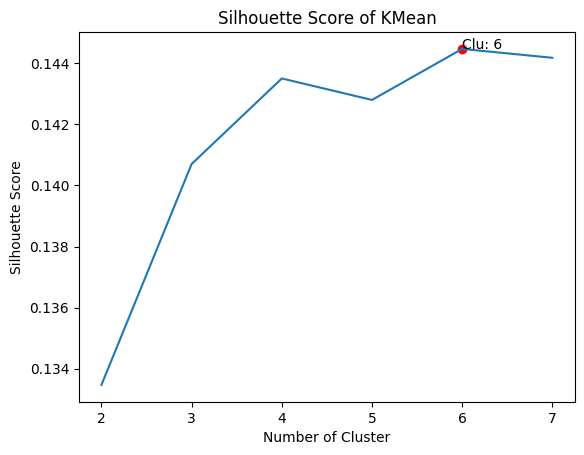

In [19]:
clusters = []
scores = []
for i in range(2,8):
    kmean_clu = KMeans(n_clusters=i,n_init='auto',random_state=randomness)
    kmean_clu.fit(scaled_train_x)
    score = silhouette_score(scaled_train_x,kmean_clu.labels_,random_state=randomness)
    clusters.append(i)
    scores.append(score)

best_score = scores[np.argmax(np.array(scores))]
best_score_cluster = clusters[np.argmax(np.array(scores))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(clusters,scores)
ax.scatter([best_score_cluster],[best_score],color='red')
ax.annotate("Clu: {}".format(best_score_cluster),xy=(best_score_cluster,best_score))
ax.set_xlabel("Number of Cluster")
ax.set_ylabel("Silhouette Score")
ax.set_title("Silhouette Score of KMean")
plt.show()


##### Creating Model Pipe

In [20]:
model_pipe_kmean = Pipeline([
    ('kmean_clu', KMeans(n_clusters=best_score_cluster,random_state=randomness,n_init='auto')),
    ('skl_clf', clone(stk_clf))
])

get_primary_view(model_pipe_kmean,scaled_train_x,encoded_train_y,scaled_val_x,encoded_val_y)

Cross Validation Score

Total Number of scores: 10
Mean Score:    0.82
Max Score:     0.85
Min Score:     0.8
St. Daviation: 0.018
Scores:        [0.80882353 0.85294118 0.80882353 0.80514706 0.80147059 0.83823529
 0.81985294 0.82352941 0.8125     0.84926471]

Validation Score

Accuracy Score: 0.8229166666666666
Confusion Matrix:
[[200  40]
 [ 45 195]]



##### Trying BayesianGaussianMixture

In [21]:
model_pipe_bgm = Pipeline([
    ('bgm_clu', CustomModel(BayesianGaussianMixture(n_components=10,random_state=randomness,max_iter=10000))),
    ('skl_clf', clone(stk_clf))
])

get_primary_view(model_pipe_bgm,scaled_train_x,encoded_train_y,scaled_val_x,encoded_val_y)

Cross Validation Score

Total Number of scores: 10
Mean Score:    0.97
Max Score:     0.99
Min Score:     0.96
St. Daviation: 0.01
Scores:        [0.96323529 0.98529412 0.96323529 0.98529412 0.96323529 0.96691176
 0.96323529 0.95955882 0.95955882 0.97794118]

Validation Score

Accuracy Score: 0.9729166666666667
Confusion Matrix:
[[233   7]
 [  6 234]]



**Therefore the best model is Stacking Classifier with BayesianGaussianMixture**

### Training Final Model 

In [22]:
final_model = clone(model_pipe_bgm)

final_model.fit(scaled_train_x,encoded_train_y)

Pipeline(steps=[('bgm_clu',
                 CustomModel(model=BayesianGaussianMixture(max_iter=10000,
                                                           n_components=10,
                                                           random_state=42))),
                ('skl_clf',
                 StackingClassifier(cv=3,
                                    estimators=[('log_reg',
                                                 LogisticRegression(random_state=42)),
                                                ('sgd_clf',
                                                 SGDClassifier(early_stopping=True,
                                                               max_iter=20000,
                                                               penalty='elasticnet',
                                                               random_state=42)),
                                                ('svc_clf',
                                                 SVC(random_state=42)),
                                                ('dtree_clf',
                                                 DecisionTreeClassifier(min_samples_leaf=4,
                                                                        random_state=42))],
                                    final_estimator=LogisticRegression()))])

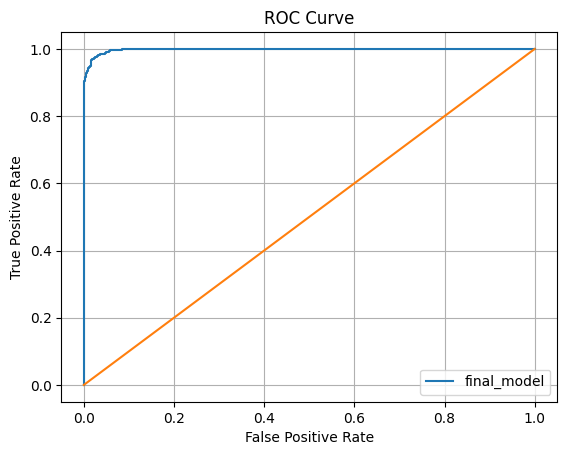

In [23]:
plot_rocs([('final_model',final_model)],scaled_train_x,encoded_train_y)

### SCORE IN TEST SET (UNSEEN DATA)

In [24]:
scaled_test_x = x_scaler.transform(test_x)
encoded_test_y = y_encoder.transform(test_y)

final_predict = final_model.predict(scaled_test_x)

view_score(encoded_test_y,final_predict)


Accuracy Score: 0.96375
Confusion Matrix:
[[387  12]
 [ 17 384]]



### Creating Pipeline on final model

In [25]:
pipeline_final = Pipeline([
    ('x_floater',X_Floater()),
    ('x_scaler',StandardScaler()),
    ('bgm_clu', CustomModel(BayesianGaussianMixture(n_components=10,random_state=randomness,max_iter=10000))),
    ('skl_clf', clone(stk_clf))
])


pipeline_final.fit(train_x,encoded_train_y)

Pipeline(steps=[('x_floater', X_Floater()), ('x_scaler', StandardScaler()),
                ('bgm_clu',
                 CustomModel(model=BayesianGaussianMixture(max_iter=10000,
                                                           n_components=10,
                                                           random_state=42))),
                ('skl_clf',
                 StackingClassifier(cv=3,
                                    estimators=[('log_reg',
                                                 LogisticRegression(random_state=42)),
                                                ('sgd_clf',
                                                 SGDClassifier(early_stopping=True,
                                                               max_iter=20000,
                                                               penalty='elasticnet',
                                                               random_state=42)),
                                                ('svc_clf',
                                                 SVC(random_state=42)),
                                                ('dtree_clf',
                                                 DecisionTreeClassifier(min_samples_leaf=4,
                                                                        random_state=42))],
                                    final_estimator=LogisticRegression()))])

In [26]:
encoded_test_y = y_encoder.transform(test_y)

final_predict = pipeline_final.predict(test_x)

view_score(encoded_test_y,final_predict)


Accuracy Score: 0.96375
Confusion Matrix:
[[387  12]
 [ 17 384]]



In [27]:
## Displaying Few test samples

indexes = []
originals = []
predicted = []
for i in range(10,21):
    predict = pipeline_final.predict(test_x[i].reshape(1,len(test_x[i])))
    original = test_y[i]
    indexes.append(i)
    originals.append(original)
    predicted.append(y_encoder.inverse_transform(predict))

pd.DataFrame(np.c_[indexes,originals,predicted],columns=['index','original','predicted'])  

,index,original,predicted
0,10,bad,bad
1,11,bad,bad
2,12,bad,bad
3,13,bad,bad
4,14,bad,bad
5,15,good,good
6,16,good,good
7,17,bad,bad
8,18,good,good
9,19,bad,bad
